In [1]:
import os
import glob
import csv

In [17]:
PARENT = "/data/holly_jackson/experiments"
out_csv = "summary_metrics_test.csv"
# exp_name_format = "coord-descent-aif-init-????_2025-08-20_*"
exp_name_format = "test2-????_2025-08-20_*"

In [18]:
def parse_last_loss(losses_path):
    # todo: this reads whole file not super efficient
    with open(losses_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip(): # not blank
                last = line.strip()
    return float(last)

def parse_accuracy_metrics(metrics_path):
    rms = rel = d1 = d2 = d3 = None
    with open(metrics_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.lower().startswith("rms"):
                rms = float(line.split(":")[1].strip())
            elif line.lower().startswith("rel"):
                rel = float(line.split(":")[1].strip())
            elif line.lower().startswith("accuracy"):
                right = line.split(":")[1].strip()
                d1, d2, d3 = [float(x.strip()) for x in right.split(",")]
    return (rms, rel, d1, d2, d3)

In [19]:
rows = []
pattern = os.path.join(PARENT, exp_name_format)
dirs = [d for d in glob.glob(pattern) if os.path.isdir(d)]

# remove repeats + sort
dirs = sorted(set(dirs))

for d in dirs:
    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # print(run_id)
        
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")

    last_loss = parse_last_loss(losses_path)
    # print(last_loss)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    # print(rms, rel, d1, d2, d3)

    rows.append({
        "run_id": run_id,
        "last_loss": last_loss,
        "RMS": rms,
        "Rel": rel,
        "delta1": d1,
        "delta2": d2,
        "delta3": d3,
    })


# write to csv all at once
fieldnames = ["run_id", "last_loss", "RMS", "Rel", "delta1", "delta2", "delta3"]
rows.sort(key=lambda r: r["run_id"])

avg_row = {"run_id": "AVERAGE"}
for col in fieldnames[1:]:
    values = [r[col] for r in rows if r[col] is not None]
    avg_row[col] = sum(values) / len(values) if values else None

rows.append(avg_row)

with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=fieldnames
    )
    writer.writeheader()
    writer.writerows(rows)

print(f"Wrote {len(rows)} rows to {out_csv}")

/data/holly_jackson/experiments/test2-0003_2025-08-20_12-42-05
0003
6.493447780609131
0.67534 0.249947 0.722539 0.883893 0.942461
/data/holly_jackson/experiments/test2-0004_2025-08-20_12-42-05
0004
7.9479193687438965
0.882461 0.371808 0.580326 0.901328 0.943268
/data/holly_jackson/experiments/test2-0005_2025-08-20_12-42-05
0005
4.447852611541748
0.940131 0.207543 0.669818 0.914987 0.946693
/data/holly_jackson/experiments/test2-0006_2025-08-20_12-42-04
0006
3.2350594997406006
1.189436 0.23202 0.505703 0.890117 0.938685
/data/holly_jackson/experiments/test2-0007_2025-08-20_12-42-05
0007
3.9427733421325684
1.69731 0.307795 0.324909 0.715924 0.88918
/data/holly_jackson/experiments/test2-0008_2025-08-20_12-42-04
0008
4.583017349243164
0.850014 0.211417 0.795299 0.885781 0.938607
/data/holly_jackson/experiments/test2-0010_2025-08-20_12-42-06
0010
4.4719061851501465
1.053727 0.263847 0.732331 0.848255 0.91806
/data/holly_jackson/experiments/test2-0011_2025-08-20_12-42-05
0011
8.08393001556396

In [20]:
import utils 
import forward_model
import globals

globals.init_NYUv2()

IMAGE_RANGE = 255.

# load data 
gt_aif, gt_dpt = utils.load_single_sample(sample='0045', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

defocus_stack = forward_model.forward(gt_dpt, gt_aif)


480 640
480 640
adaptive kernel size set to 11


In [32]:
d = '/data/holly_jackson/experiments/test2-0045_2025-08-20_12-42-06'

dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE

    
defocus_stack_test = forward_model.forward(dpt_test, aif_test)


240 320
240 320


In [33]:
import coordinate_descent
import math

mse_test = coordinate_descent.mse_loss(defocus_stack_test, defocus_stack)
rms_test = utils.compute_RMS(dpt_test, gt_dpt)
rel_test = utils.compute_Rel(dpt_test, gt_dpt)
deltas_test = utils.compute_accuracy_metrics(dpt_test, gt_dpt)

print(mse_test, last_loss)
assert math.isclose(mse_test, last_loss, rel_tol=1e-6, abs_tol=1e-6)

print(rms_test, rms)
assert math.isclose(rms_test, rms, rel_tol=1e-6, abs_tol=1e-6)

print(rel_test, rel)
assert math.isclose(rel_test, rel, rel_tol=1e-6, abs_tol=1e-6)

print(deltas_test, d1, d2, d3)
assert math.isclose(deltas_test["delta1"], d1, rel_tol=1e-6, abs_tol=1e-6)
assert math.isclose(deltas_test["delta2"], d2, rel_tol=1e-6, abs_tol=1e-6)
assert math.isclose(deltas_test["delta3"], d3, rel_tol=1e-6, abs_tol=1e-6)

8.896098 4.231045722961426


AssertionError: 

0.0 1.0


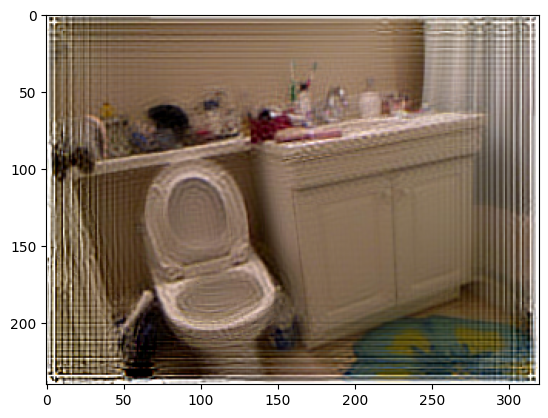

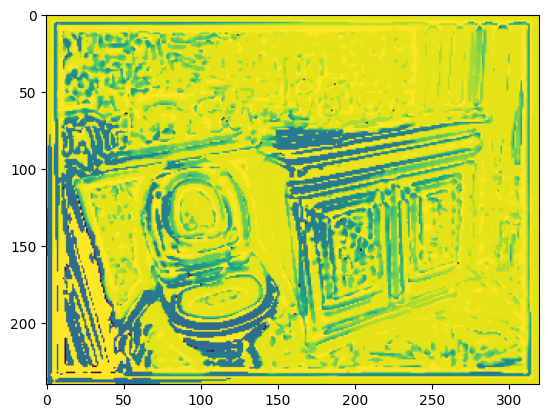

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006699229..1.0276929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006528925..1.0229076].


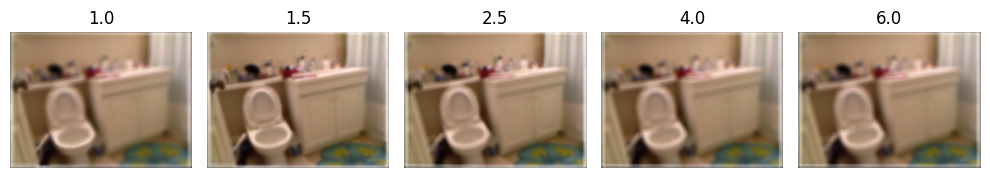

In [31]:
import matplotlib.pyplot as plt
print(aif_test.min(), aif_test.max())
plt.imshow(aif_test )
plt.show()

plt.imshow(dpt_test, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

utils.plot_single_stack(defocus_stack_test, globals.Df)